# Classification Model(K-Means) applied on the interests of People on local Venues

In [38]:
#importing various libraries
import requests 
import pandas as pd
import numpy as np 
import random 
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt 
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import folium
import geocoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
#User enters the location to do some analysis
loc = input("Enter the location :")

Enter the location :Southampton


In [3]:
#getting the co-ordinates of the location
geolocator = Nominatim(user_agent="uk")
address = str(loc +", United Kingdom")
location = geocoder.arcgis(address)
latlang = location.latlng

In [4]:
#plotting the map of the location entered
map_loc=folium.Map(location=[latlang[0],latlang[1]],zoom_start=14)
map_loc

In [5]:
#Importing the dataset which contains all the neighboorhoods of the locations 
loc_neighborhoods = pd.read_excel(r'C:/Users/hp/dissertation/Datasets/top25.xlsx',sheet_name='Sheet2')
#selecting the neighborhoods from the city selected
loc_neighborhoods=loc_neighborhoods[loc_neighborhoods.city==loc]
loc_neighborhoods.drop('city',inplace=True,axis=1)
loc_neighborhoods.head()

,neighborhood
402,Bargate
403,Bassett
404,Bevois
405,Bitterne
406,Bitterne Park


In [7]:
# defining the function for geopy library to get latitude and longitude for all the neighborhoods
def getNeighborhoodLatLong(Neighborhoods):
    
    #Neighborhood with lat , long
    latlang = []
    # defining the user agent for geopy
    geolocator = Nominatim(user_agent="uk_neighborhoods")
    
    # for every unique  of Neighborhood  get the lattitude and longitude
    for  neigh in Neighborhoods:
        address = str(neigh +", {}".format(loc))
        location = geocoder.arcgis(address)
        latlang.append(location.latlng)
    
    return(latlang)

In [8]:
#applying the function on neighboorhoods to get the neighboorhoods
loc_neigh = getNeighborhoodLatLong(Neighborhoods = loc_neighborhoods["neighborhood"])

In [9]:
#checking the top 5 values of locations
loc_neigh[:5]

[[50.90265000000005, -1.4041899999999714],
 [50.947819490224404, -1.4045911432397613],
 [50.91969010144991, -1.3953344241759458],
 [50.914540000000045, -1.338459999999941],
 [50.91483967933845, -1.3632775884247788]]

In [10]:
#splitting the co-ordinates of the locations 
latitude= []
longitude = []
for lat, lng in loc_neigh:
    latitude.append(lat)
    longitude.append(lng)

print(latitude[0:5])
print(longitude[0:5])

[50.90265000000005, 50.947819490224404, 50.91969010144991, 50.914540000000045, 50.91483967933845]
[-1.4041899999999714, -1.4045911432397613, -1.3953344241759458, -1.338459999999941, -1.3632775884247788]


In [11]:
#appending the values of co-ordinates to the dataframe
loc_neighborhoods["Latitude"] = latitude
loc_neighborhoods["Longitude"] = longitude

loc_neighborhoods.head()

,neighborhood,Latitude,Longitude
402,Bargate,50.902650,-1.404190
403,Bassett,50.947819,-1.404591
404,Bevois,50.919690,-1.395334
405,Bitterne,50.914540,-1.338460
406,Bitterne Park,50.914840,-1.363278


In [12]:
#plotting the locations and areas within the location
map_loc=folium.Map(location=[latlang[0],latlang[1]],zoom_start=10)
for lat,lng,neighborhood in zip(loc_neighborhoods['Latitude'],loc_neighborhoods['Longitude'],loc_neighborhoods['neighborhood']):
    label='{}'.format(neighborhood)
    folium.CircleMarker([lat,lng],color='red',popup=label,fill=True,fill_color='red',fill_opacity=0.6).add_to(map_loc)
map_loc    

In [13]:
#the key ids used in foursquare API to fetch the data 
CLIENT_ID = 'WXER4KXQTW0IHEGA0HLO2EMDOOWEZKAX4YFQLRDMZ2TSBRVM'  # your Foursquare ID
CLIENT_SECRET = '4NMKXNOKJBU4FR312SHLECHR1WSY0ONMQP2JXUYOZ0TWKTJG'  # your Foursquare Secret
VERSION = '20210118'  # Foursquare API version taking last month api for analysis

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WXER4KXQTW0IHEGA0HLO2EMDOOWEZKAX4YFQLRDMZ2TSBRVM
CLIENT_SECRET:4NMKXNOKJBU4FR312SHLECHR1WSY0ONMQP2JXUYOZ0TWKTJG


In [14]:
# API KEY for foursquare API
API_KEY='fsq3lREtx31InF1Fo6N72vvhvlJsyukU2DtVPxkju8HMVGU='

In [17]:
#defining a function to get the nearby venues of the locations

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 1000

    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([
            (name, lat, lng, v['venue']['name'], v['venue']['location']['lat'],
             v['venue']['location']['lng'],
             v['venue']['categories'][0]['name']) for v in results
        ])

    nearby_venues = pd.DataFrame(
        [item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
        'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'
    ]

    return (nearby_venues)

In [18]:
#applying the function on all the areas to get the venues
loc_venues = getNearbyVenues(names=loc_neighborhoods['neighborhood'],
                                latitudes=loc_neighborhoods['Latitude'],
                                longitudes=loc_neighborhoods['Longitude'])

Bargate
Bassett
Bevois
Bitterne
Bitterne Park
Coxford
Freemantle
Harefield
Millbrook
Peartree
Portswood
Redbridge
Shirley
Sholing
Swaythling
Woolston


In [19]:
#printing the location venues and shape
print(loc_venues.shape)
loc_venues

(175, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bargate,50.902650,-1.40419,Showcase Cinema de Lux,50.902088,-1.407260,Movie Theater
1,Bargate,50.902650,-1.40419,Apple Southampton,50.904082,-1.405050,Electronics Store
2,Bargate,50.902650,-1.40419,Cafe Thrive,50.902995,-1.401872,Café
3,Bargate,50.902650,-1.40419,Pret A Manger,50.904087,-1.404636,Sandwich Place
4,Bargate,50.902650,-1.40419,Waterstones,50.903190,-1.405865,Bookstore
...,...,...,...,...,...,...,...
170,Woolston,50.888353,-1.37232,Weston Shore,50.886414,-1.374114,Beach
171,Woolston,50.888353,-1.37232,Co-op Food,50.889407,-1.367750,Grocery Store
172,Woolston,50.888353,-1.37232,Forest Flame Disco,50.888281,-1.376445,Entertainment Service
173,Woolston,50.888353,-1.37232,Domino's Pizza,50.889232,-1.368329,Pizza Place


In [20]:
#counting the count of areas in neighboorhoods
loc_neighborhoods["neighborhood"].value_counts().count()

16

In [21]:
#counting the number of areas in venues
loc_venues["Neighborhood"].value_counts().count()

16

In [22]:
#creating a dataframe in which the areas in neighboorhod is there in venues
loc_neighborhoods = loc_neighborhoods.loc[loc_neighborhoods["neighborhood"].isin(loc_venues["Neighborhood"])]
#counting the locations
loc_neighborhoods["neighborhood"].value_counts().count()

16

In [23]:
#checking the top5 rows 
loc_neighborhoods.head()

,neighborhood,Latitude,Longitude
402,Bargate,50.902650,-1.404190
403,Bassett,50.947819,-1.404591
404,Bevois,50.919690,-1.395334
405,Bitterne,50.914540,-1.338460
406,Bitterne Park,50.914840,-1.363278


In [24]:
#grouping the dataframe with repect to neighborhood
loc_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bargate,52,52,52,52,52,52
Bassett,2,2,2,2,2,2
Bevois,22,22,22,22,22,22
Bitterne,5,5,5,5,5,5
Bitterne Park,10,10,10,10,10,10
Coxford,4,4,4,4,4,4
Freemantle,5,5,5,5,5,5
Harefield,11,11,11,11,11,11
Millbrook,4,4,4,4,4,4


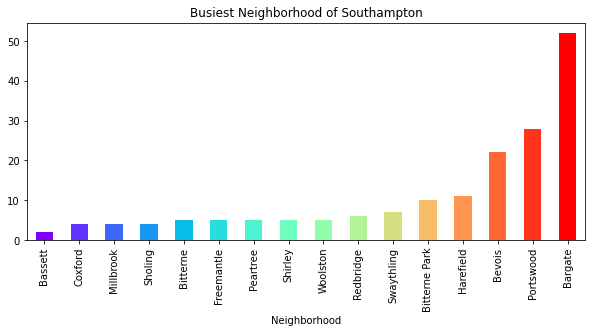

In [25]:
#plotting the most popular venue as per data received from API
pop_loc_venues = loc_venues.groupby('Neighborhood').count()
fig = plt.figure(figsize=(10,4))
colormap = cm.rainbow(np.linspace(0, 1, pop_loc_venues.shape[0]))
plt.title("Busiest Neighborhood of {}".format(loc))
ax = pop_loc_venues["Venue Category"].sort_values().plot.bar(color = colormap)

#### From the above chart we can clearly see that the bargate area of the location has the most footfalls. and is most visited by the people.

In [26]:
#Counting the number of uniques categories of venues
print('There are {} uniques categories.'.format(len(loc_venues['Venue Category'].unique())))

There are 74 uniques categories.


In [27]:
# Applying one hot encoding on the dataset
loc_onehot = pd.get_dummies(loc_venues[['Venue Category']], prefix="", prefix_sep="")
loc_onehot['Neighborhood'] = loc_venues['Neighborhood'] 
loc_onehot.head()

,American Restaurant,Arcade,Asian Restaurant,Auto Workshop,BBQ Joint,Bar,Beach,Bookstore,Bowling Alley,Breakfast Spot,...,Shopping Mall,Ski Area,Sporting Goods Shop,Steakhouse,Supermarket,Tapas Restaurant,Thai Restaurant,Train Station,Turkish Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bargate
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bargate
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bargate
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bargate
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Bargate


In [28]:
#checking the shape of the dataset
loc_onehot.shape

(175, 75)

In [29]:
#grouping the dataset with respect to neighborhood
loc_grouped = loc_onehot.groupby('Neighborhood').mean().reset_index()
loc_grouped

,Neighborhood,American Restaurant,Arcade,Asian Restaurant,Auto Workshop,BBQ Joint,Bar,Beach,Bookstore,Bowling Alley,...,Sandwich Place,Shopping Mall,Ski Area,Sporting Goods Shop,Steakhouse,Supermarket,Tapas Restaurant,Thai Restaurant,Train Station,Turkish Restaurant
0,Bargate,0.000000,0.0,0.019231,0.019231,0.019231,0.000000,0.0,0.038462,0.00,...,0.019231,0.019231,0.0,0.019231,0.019231,0.000000,0.000000,0.019231,0.000000,0.019231
1,Bassett,0.000000,0.5,0.000000,0.000000,0.000000,0.500000,0.0,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bevois,0.045455,0.0,0.000000,0.000000,0.000000,0.181818,0.0,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.000000,0.045455,0.045455,0.000000,0.000000,0.000000
3,Bitterne,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bitterne Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000
5,Coxford,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Freemantle,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Harefield,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000
8,Millbrook,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.25,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Peartree,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
#calculating the frequency of the venues as per the areas
num_top_venues = 5
for hood in loc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = loc_grouped[loc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [31]:
#defining a function which returns the sorted venues list
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
#creating a dataframe which shows top 10 most common venues
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = loc_grouped['Neighborhood']
for ind in np.arange(loc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(loc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bargate,Italian Restaurant,Hotel,Coffee Shop,Pub,Portuguese Restaurant,Bookstore,Furniture / Home Store,Historic Site,Clothing Store,Park
1,Bassett,Arcade,Bar,Kids Store,Park,Outdoor Supply Store,Nightclub,Newsagent,Movie Theater,Middle Eastern Restaurant,Mexican Restaurant
2,Bevois,Pub,Bar,Mexican Restaurant,American Restaurant,Convenience Store,Tapas Restaurant,Supermarket,Hookah Bar,Grocery Store,Greek Restaurant
3,Bitterne,Grocery Store,Fast Food Restaurant,Pizza Place,Indian Restaurant,American Restaurant,Outdoor Supply Store,Nightclub,Newsagent,Movie Theater,Middle Eastern Restaurant
4,Bitterne Park,Pharmacy,Gift Shop,Pizza Place,Fast Food Restaurant,Bus Stop,Park,Gym / Fitness Center,Supermarket,Grocery Store,Indian Restaurant


Text(0, 0.5, 'Interia')

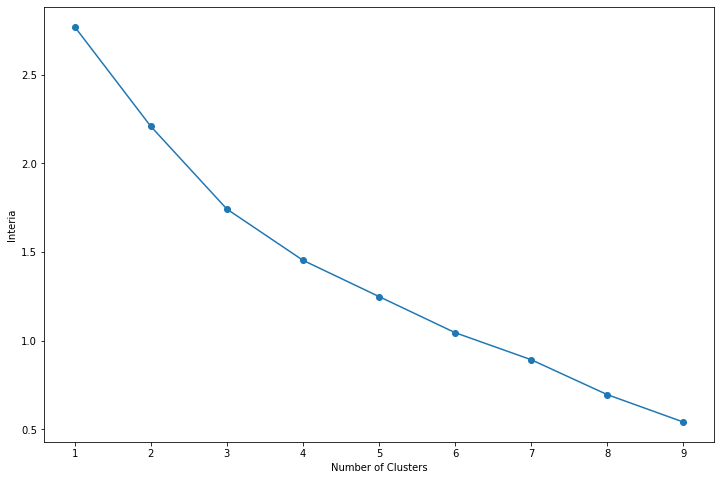

In [37]:
# elbow method for calculating the number of clusters

loc_grouped_clustering = loc_grouped.drop('Neighborhood', 1)

clus =[]
for cluster in range(1,10):
    modl = KMeans(n_clusters=cluster, init='k-means++')
    modl.fit(loc_grouped_clustering)
    clus.append(modl.inertia_)

temp = pd.DataFrame({'Cluster': range(1,10), 'cluster_list':clus})
plt.figure(figsize=(12,8))
plt.plot(temp['Cluster'],temp['cluster_list'], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Interia')

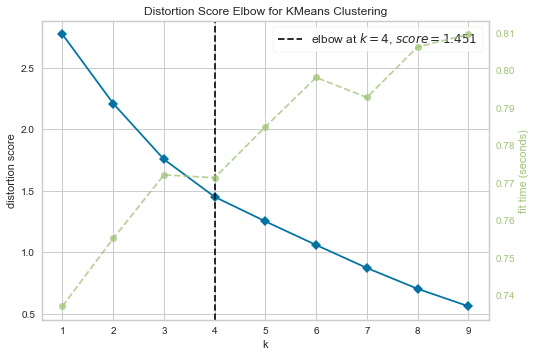

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
#Visualizing the ELbow method with distortion score
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10)).fit(loc_grouped_clustering)
visualizer.show()

### Setting the number of clusters as 4.

#### Applying KMeans Clustering 

In [42]:
kclusters = 4
loc_grouped_clustering = loc_grouped.drop('Neighborhood', 1)
# applying model
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(loc_grouped_clustering)
# checking the clusters
kmeans.labels_

array([0, 3, 0, 2, 0, 1, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2])

In [43]:
#adding the labels to the dataframe
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
loc_merged = loc_neighborhoods
loc_merged = loc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')
loc_merged.head()

,neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
402,Bargate,50.902650,-1.404190,0,Italian Restaurant,Hotel,Coffee Shop,Pub,Portuguese Restaurant,Bookstore,Furniture / Home Store,Historic Site,Clothing Store,Park
403,Bassett,50.947819,-1.404591,3,Arcade,Bar,Kids Store,Park,Outdoor Supply Store,Nightclub,Newsagent,Movie Theater,Middle Eastern Restaurant,Mexican Restaurant
404,Bevois,50.919690,-1.395334,0,Pub,Bar,Mexican Restaurant,American Restaurant,Convenience Store,Tapas Restaurant,Supermarket,Hookah Bar,Grocery Store,Greek Restaurant
405,Bitterne,50.914540,-1.338460,2,Grocery Store,Fast Food Restaurant,Pizza Place,Indian Restaurant,American Restaurant,Outdoor Supply Store,Nightclub,Newsagent,Movie Theater,Middle Eastern Restaurant
406,Bitterne Park,50.914840,-1.363278,0,Pharmacy,Gift Shop,Pizza Place,Fast Food Restaurant,Bus Stop,Park,Gym / Fitness Center,Supermarket,Grocery Store,Indian Restaurant


In [45]:
# create map with clustersing
map_clusters = folium.Map(location=[latlang[0], latlang[1]], zoom_start=12.3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(loc_merged['Latitude'], loc_merged['Longitude'], loc_merged['neighborhood'], loc_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster + 1) + str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<AxesSubplot:title={'center':'Busiest Venues of Southampton per culster'}, xlabel='Cluster Labels,1st Most Common Venue'>

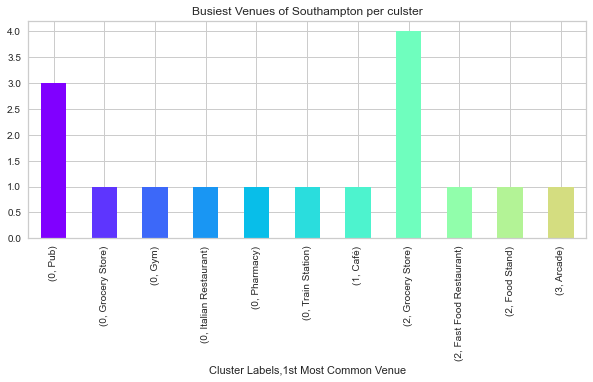

In [46]:
#plotting the bar chart of the busiest venues
tmp = loc_merged.groupby("Cluster Labels")["1st Most Common Venue"]
fig = plt.figure(figsize=(10,4))
colormap = cm.rainbow(np.linspace(0, 1, pop_loc_venues.shape[0]))
plt.title("Busiest Venues of {} per culster".format(loc))
tmp.value_counts().plot.bar(color = colormap)

#### Cluster No 1:

In [47]:
clus1 = loc_merged.loc[loc_merged['Cluster Labels'] == 0]
clus1.head()

,neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
402,Bargate,50.90265,-1.404190,0,Italian Restaurant,Hotel,Coffee Shop,Pub,Portuguese Restaurant,Bookstore,Furniture / Home Store,Historic Site,Clothing Store,Park
404,Bevois,50.91969,-1.395334,0,Pub,Bar,Mexican Restaurant,American Restaurant,Convenience Store,Tapas Restaurant,Supermarket,Hookah Bar,Grocery Store,Greek Restaurant
406,Bitterne Park,50.91484,-1.363278,0,Pharmacy,Gift Shop,Pizza Place,Fast Food Restaurant,Bus Stop,Park,Gym / Fitness Center,Supermarket,Grocery Store,Indian Restaurant
408,Freemantle,50.91338,-1.424640,0,Pub,Convenience Store,Fish & Chips Shop,Grocery Store,Park,Outdoor Supply Store,Nightclub,Newsagent,Movie Theater,Middle Eastern Restaurant
411,Peartree,50.92822,-1.280820,0,Gym,Hotel,Diner,Playground,Pub,American Restaurant,Middle Eastern Restaurant,Outdoor Supply Store,Nightclub,Newsagent


In [48]:
#making a temperary dataframe for plotting on map
dft_tmp_clus1 = pd.DataFrame(
    clus1.groupby("neighborhood")["1st Most Common Venue"].apply(
        lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus1.rename(columns={
    'neighborhood': 'neighborhood',
    '1st Most Common Venue': 'top_venues'
},
                     inplace=True)
dft_tmp_clus1["top_venues"].values

array(['Italian Restaurant', 'Pub', 'Pharmacy', 'Pub', 'Gym',
       'Grocery Store', 'Train Station', 'Pub'], dtype=object)

### We can see that the venues in Cluster 1 is majority is of Pubs.

## Cluster No 2:

In [49]:
clus2 = loc_merged.loc[loc_merged['Cluster Labels'] == 1]
clus2.head()

,neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
407,Coxford,50.936443,-1.430981,1,Café,Grocery Store,Newsagent,American Restaurant,Mexican Restaurant,Park,Outdoor Supply Store,Nightclub,Movie Theater,Middle Eastern Restaurant


In [50]:
#creating a dataframe for plotting on map
dft_tmp_clus2 = pd.DataFrame(
    clus2.groupby("neighborhood")["1st Most Common Venue"].apply(
        lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus2.rename(columns={
    'neighborhood': 'neighborhood',
    '1st Most Common Venue': 'top_venues'
},
                     inplace=True)
dft_tmp_clus2["top_venues"].values

array(['Café'], dtype=object)

### Cluster no 2 basically consists of Cafes.

In [51]:
clus3 = loc_merged.loc[loc_merged['Cluster Labels'] == 2]
clus3.head()

,neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
405,Bitterne,50.914540,-1.338460,2,Grocery Store,Fast Food Restaurant,Pizza Place,Indian Restaurant,American Restaurant,Outdoor Supply Store,Nightclub,Newsagent,Movie Theater,Middle Eastern Restaurant
409,Harefield,50.937075,-1.384875,2,Grocery Store,Fast Food Restaurant,Rock Club,Restaurant,Pizza Place,Playground,Convenience Store,Supermarket,Italian Restaurant,Japanese Restaurant
410,Millbrook,50.914098,-1.449217,2,Grocery Store,Outdoor Supply Store,Discount Store,Bowling Alley,American Restaurant,Middle Eastern Restaurant,Park,Nightclub,Newsagent,Movie Theater
415,Sholing,50.897190,-1.348655,2,Grocery Store,Photography Studio,Bus Stop,Mexican Restaurant,Park,Outdoor Supply Store,Nightclub,Newsagent,Movie Theater,Middle Eastern Restaurant
416,Swaythling,50.939598,-1.382364,2,Fast Food Restaurant,Grocery Store,Sandwich Place,Restaurant,Convenience Store,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kids Store,Mexican Restaurant


In [52]:
#creating a temporary dataframe to plot on map
dft_tmp_clus3 = pd.DataFrame(
    clus3.groupby("neighborhood")["1st Most Common Venue"].apply(
        lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus3.rename(columns={
    'neighborhood': 'neighborhood',
    '1st Most Common Venue': 'top_venues'
},
                     inplace=True)
dft_tmp_clus3["top_venues"].values

array(['Grocery Store', 'Grocery Store', 'Grocery Store', 'Grocery Store',
       'Fast Food Restaurant', 'Food Stand'], dtype=object)

### We can see that Cluster No 3 consists of Grocery stores  , i.e. Supermarkets

In [53]:
clus4 = loc_merged.loc[loc_merged['Cluster Labels'] == 3]
clus4.head()

,neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
403,Bassett,50.947819,-1.404591,3,Arcade,Bar,Kids Store,Park,Outdoor Supply Store,Nightclub,Newsagent,Movie Theater,Middle Eastern Restaurant,Mexican Restaurant


In [54]:
#creating a temporary dataframe to plot on map
dft_tmp_clus4 = pd.DataFrame(
    clus4.groupby("neighborhood")["1st Most Common Venue"].apply(
        lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus4.rename(columns={
    'neighborhood': 'neighborhood',
    '1st Most Common Venue': 'top_venues'
},
                     inplace=True)
dft_tmp_clus4["top_venues"].values

array(['Arcade'], dtype=object)

### Cluster No 4 consists of Arcade (games)

In [57]:
# create map to show the clusters
map_clusters = folium.Map(location=[latlang[0], latlang[1]], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster, top_spot in zip(
        loc_merged['Latitude'], loc_merged['Longitude'],
        loc_merged['neighborhood'], loc_merged['Cluster Labels'],
        loc_merged['1st Most Common Venue']):
    # putting the extra options to explore in each cluster on the popups
    if cluster == 0:
        label = folium.Popup("<h6> <center> Pubs </center></h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6>  : {} </h6> ".format(
            str(poi), str(top_spot),
            str(dft_tmp_clus1.loc[dft_tmp_clus1.neighborhood == neighborhood,
                                  "top_venues"].values)),
                             parse_html=False)
    elif cluster == 1:
        label = folium.Popup("<center>Museums </center>\
                             <h6><b> {}</b> : {}</h6> \
                          <h6>  : {} </h6> ".format(
            str(poi), str(top_spot),
            str(dft_tmp_clus2.loc[dft_tmp_clus2.neighborhood == neighborhood,
                                  "top_venues"].values)),
                             parse_html=False)

    elif cluster == 2:
        label = folium.Popup("<h6> <center> Bars </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6>  : {} </h6> ".format(
            str(poi), str(top_spot),
            str(dft_tmp_clus3.loc[dft_tmp_clus3.neighborhood == neighborhood,
                                  "top_venues"].values)),
                             parse_html=False)

    elif cluster == 3:
        label = folium.Popup("<h6> <center> Market </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> : {} </h6> ".format(
            str(poi), str(top_spot), 
            str(dft_tmp_clus4.loc[dft_tmp_clus4.neighborhood == neighborhood,
                                  "top_venues"].values)),
                             parse_html=False)


    folium.CircleMarker([lat, lon],
                        radius=7,
                        popup=label,
                        color=rainbow[cluster - 1],
                        fill=True,
                        fill_color=rainbow[cluster - 1],
                        fill_opacity=0.7).add_to(map_clusters)

map_clusters